In [44]:
import pandas as pd
import numpy as np
import time
import os
import multiprocessing as mp # for speeding up some process
import sys
sys.path.append('../py_model')
from utils import init_logging
import logging 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 10] # customizing


In [82]:
# loading data
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
print (df.shape)

(356251, 281)
(356251, 280)


In [83]:
df.shape

(356251, 280)

# clustering

In [91]:
def nullity_sort(df, sort=None):
    """
    Sorts a DataFrame according to its nullity, in either ascending or descending order.
    :param df: The DataFrame object being sorted.
    :param sort: The sorting method: either "ascending", "descending", or None (default).
    :return: The nullity-sorted DataFrame.
    """
    if sort == 'ascending':
        return df.iloc[np.argsort(df.count(axis='columns').values), :]
    elif sort == 'descending':
        return df.iloc[np.flipud(np.argsort(df.count(axis='columns').values)), :]
    else:
        return df


def nullity_filter(df, filter=None, p=0, n=0):
    """
    Filters a DataFrame according to its nullity, using some combination of 'top' and 'bottom' numerical and
    percentage values. 
    
    
    
    1.Percentages and numerical thresholds can be specified simultaneously: for example,
    to get a DataFrame with columns of at least 75% completeness but with no more than 5 columns, use
    `nullity_filter(df, filter='top', p=.75, n=5)`.
    
    return: The nullity-filtered `DataFrame`.
    
    parameters:
    --------------------
    df: The DataFrame whose columns are being filtered.
    param filter: The orientation of the filter being applied to the DataFrame. One of, "top", "bottom",
    or None (default). The filter will simply return the DataFrame if you leave the filter argument unspecified or
    as None.
    p: folat. A completeness ratio cut-off. If non-zero the filter will limit the DataFrame to columns with at least p
    completeness. Input should be in the range [0, 1].
    n: int. A numerical cut-off. If non-zero no more than this number of columns will be returned.
    
    """
    if filter == 'top':
        if p:
            df = df.iloc[:, [c >= p for c in df.count(axis='rows').values / len(df)]]
        if n:
            df = df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[-n:])]
    elif filter == 'bottom':
        if p:
            df = df.iloc[:, [c <= p for c in df.count(axis='rows').values / len(df)]]
        if n:
            df = df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[:n])]
    return df
n = None # by default
p = 0.8 # by default 
sort = None # by default 
method ='average' # by default
for i in range(1, 10):
    p = 1.0 * i / 10
    print ('p', p)
    df1 = df.copy()
    df1 = nullity_filter(df1, filter = 'top', n=n, p=p)
    df1 = nullity_sort(df1, sort=sort)
    print (df1.shape)


p 0.1
(356251, 279)
p 0.2
(356251, 279)
p 0.3
(356251, 252)
p 0.4
(356251, 243)
p 0.5
(356251, 240)
p 0.6
(356251, 236)
p 0.7
(356251, 173)
p 0.8
(356251, 164)
p 0.9
(356251, 144)


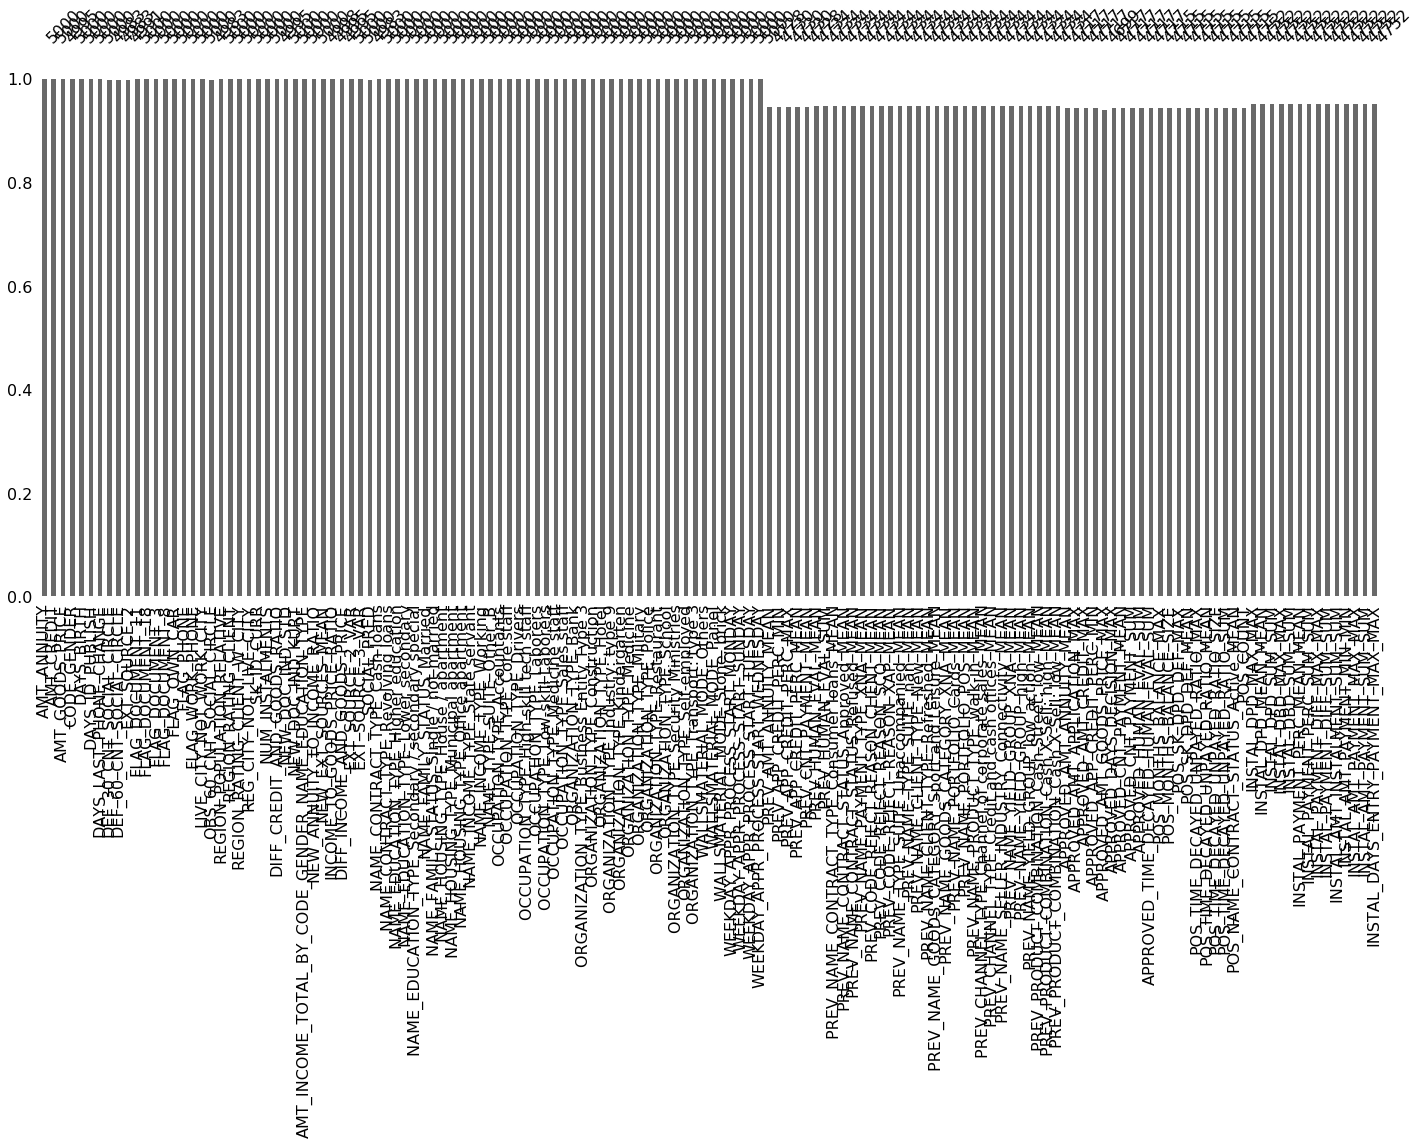

In [93]:
import missingno as msno
msno.bar(df1.sample(5000))

In [80]:
feature_clustering = pd.DataFrame({
    'features':df_transposed.index.tolist(),
    'cluster': cluster.labels_
})
feature_clustering.cluster.value_counts()

0    276
1      2
3      1
2      1
Name: cluster, dtype: int64

In [81]:
feature_clustering[feature_clustering.cluster == 1]

,features,cluster
267,CC_AMT_RECIVABLE_VAR,1
272,CC_AMT_TOTAL_RECEIVABLE_VAR,1


# correlation

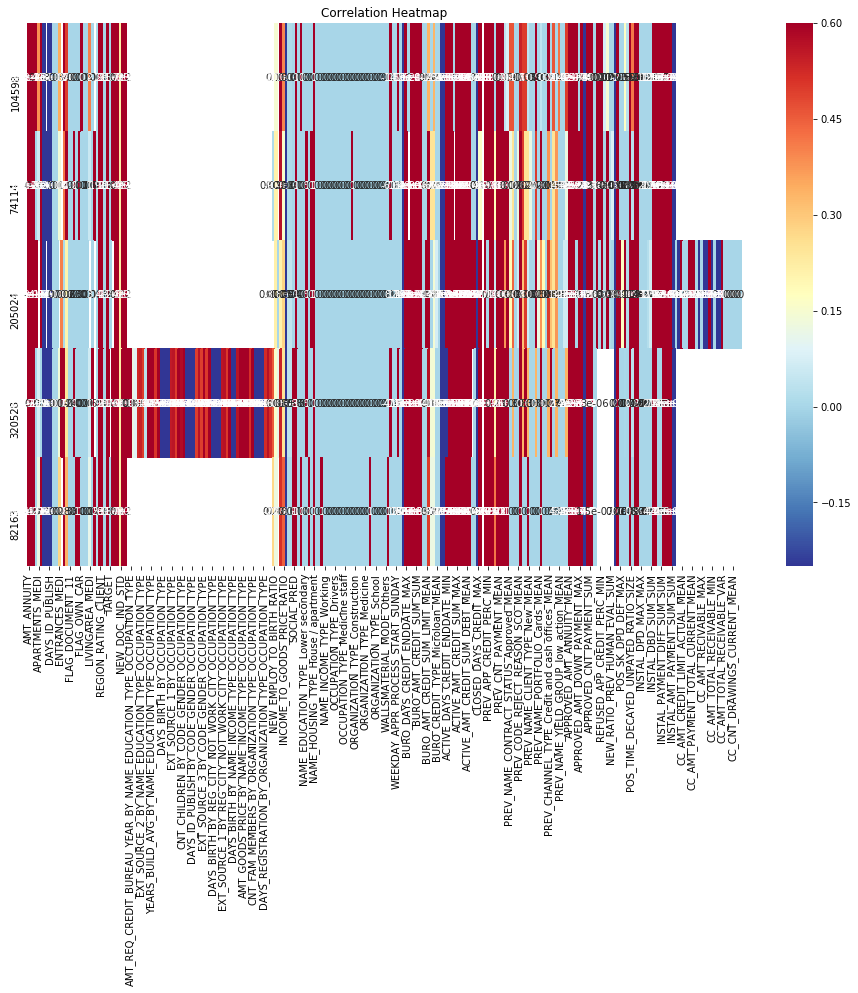

In [7]:
# Heatmap of correlations
sns.heatmap(df.sample(5), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [64]:
missing_features = []
for ix, row in df.count().iteritems():
    if row < len(df):
        missing_features.append(ix)

In [106]:
'APARTMENTS_MEDI' in missing_features

True

In [79]:
# Compute pairwise correlation of columns, excluding NA/null values
s = time.time()
corr = df.sample(20000).corr()
# 20000 x 280 ---> 8.935430526733398 secs
e  = time.time()
print (e - s)

8.232008457183838


In [80]:
corr[['TARGET']].sort_values(by = 'TARGET')

,TARGET
NEW_EXT_SOURCES_MEAN,-0.229795
NEW_SOURCES_PROD,-0.194903
EXT_SOURCE_3,-0.187368
EXT_SOURCE_2,-0.165651
EXT_SOURCE_1,-0.160644
EXT_SOURCE_1_BY_NAME_EDUCATION_TYPE_OCCUPATION_TYPE,-0.109582
EXT_SOURCE_1_BY_REG_CITY_NOT_WORK_CITY_OCCUPATION_TYPE,-0.109258
EXT_SOURCE_1_BY_NAME_INCOME_TYPE_OCCUPATION_TYPE,-0.105395
EXT_SOURCE_1_BY_OCCUPATION_TYPE,-0.101987
EXT_SOURCE_1_BY_ORGANIZATION_TYPE_OCCUPATION_TYPE,-0.096589


In [68]:
corr[(corr.AMT_ANNUITY > 0.6) | (corr.AMT_ANNUITY <= -0.6)]

,AMT_ANNUITY
AMT_ANNUITY,1.000000
AMT_CREDIT,0.760424
AMT_GOODS_PRICE,0.765011
DIFF_INCOME_AND_GOODS_PRICE,-0.683687


# the shorter bratch is, the more similar two variables are
# hierarchica clustering : https://www.youtube.com/watch?v=7xHsRkOdVwo
# Cluster_1 means the cluster with shortest branch and the featurs are most similar

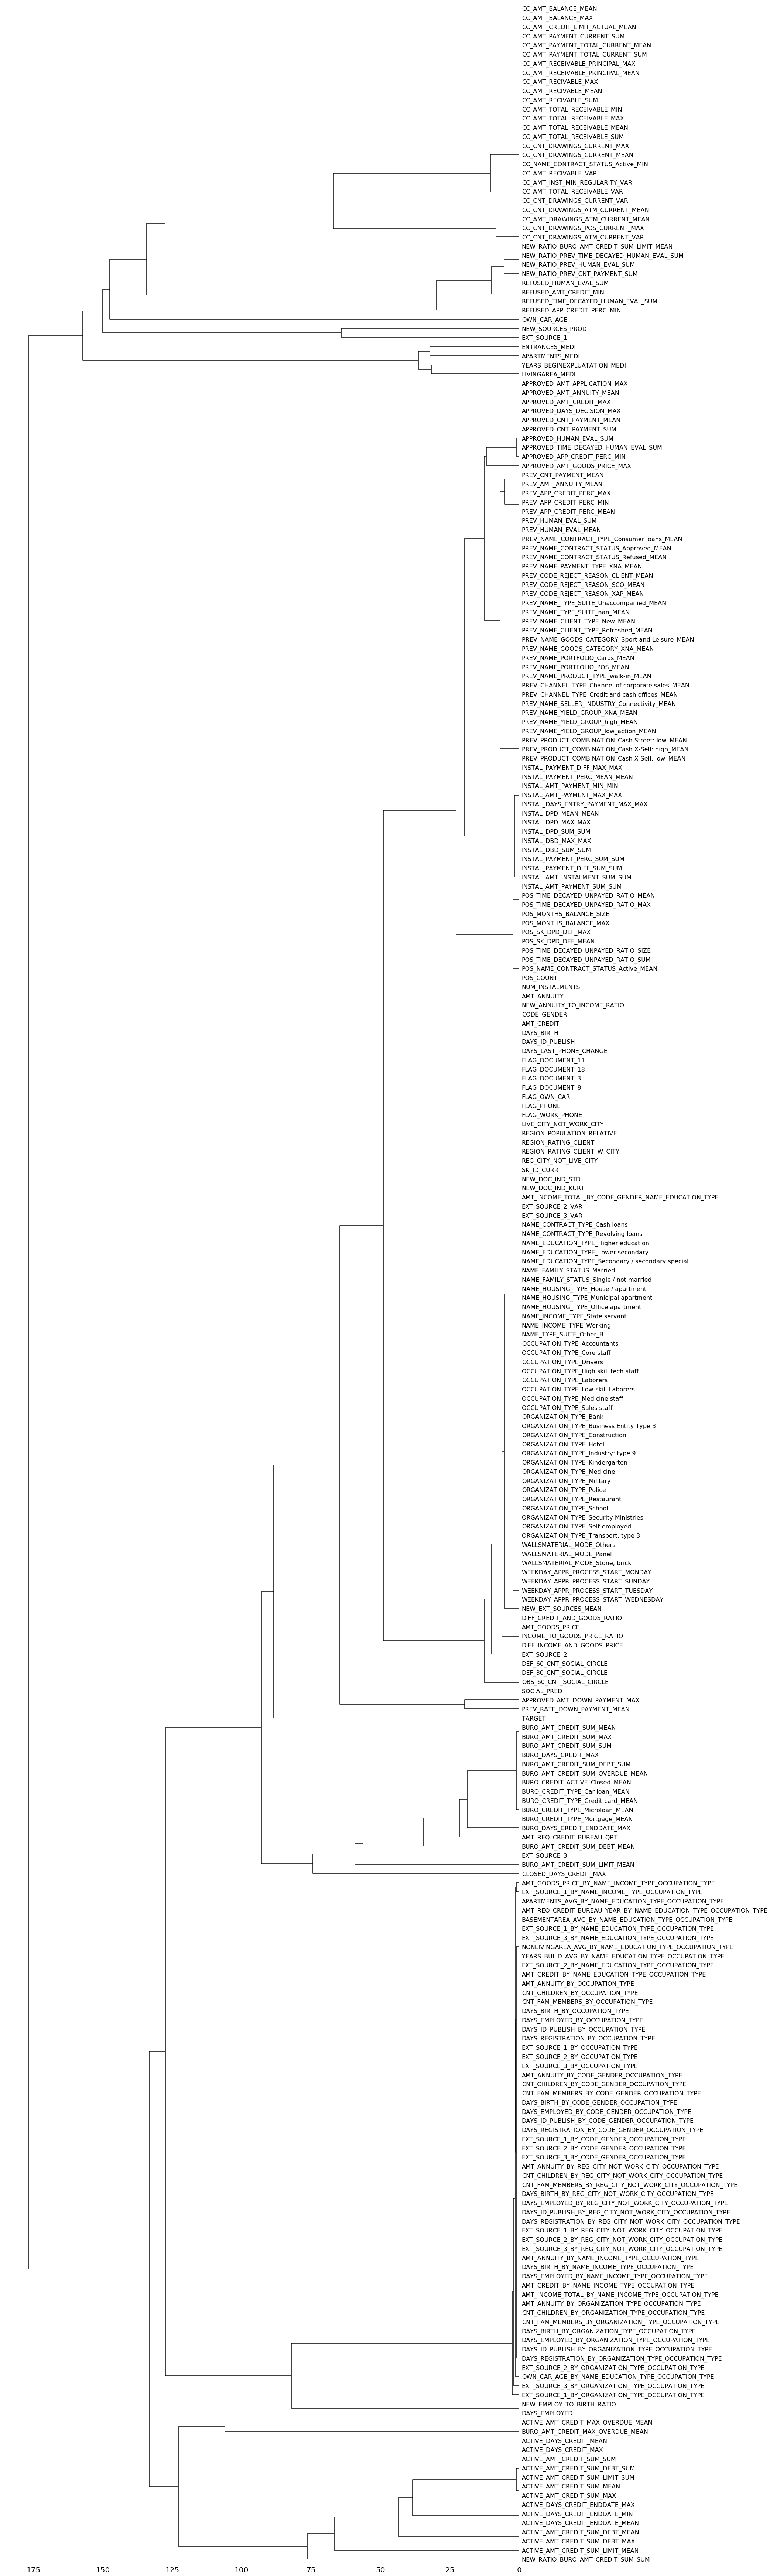

In [6]:
import missingno as msno
msno.dendrogram(df.sample(50000))
plt.savefig('../output/hierarchical_clustering.png')
# 可否打印圖出來

In [69]:
def nullity_sort(df, sort=None):
    """
    Sorts a DataFrame according to its nullity, in either ascending or descending order.
    :param df: The DataFrame object being sorted.
    :param sort: The sorting method: either "ascending", "descending", or None (default).
    :return: The nullity-sorted DataFrame.
    """
    if sort == 'ascending':
        return df.iloc[np.argsort(df.count(axis='columns').values), :]
    elif sort == 'descending':
        return df.iloc[np.flipud(np.argsort(df.count(axis='columns').values)), :]
    else:
        return df


def nullity_filter(df, filter=None, p=0, n=0):
    """
    Filters a DataFrame according to its nullity, using some combination of 'top' and 'bottom' numerical and
    percentage values. Percentages and numerical thresholds can be specified simultaneously: for example,
    to get a DataFrame with columns of at least 75% completeness but with no more than 5 columns, use
    `nullity_filter(df, filter='top', p=.75, n=5)`.
    :param df: The DataFrame whose columns are being filtered.
    :param filter: The orientation of the filter being applied to the DataFrame. One of, "top", "bottom",
    or None (default). The filter will simply return the DataFrame if you leave the filter argument unspecified or
    as None.
    :param p: A completeness ratio cut-off. If non-zero the filter will limit the DataFrame to columns with at least p
    completeness. Input should be in the range [0, 1].
    :param n: A numerical cut-off. If non-zero no more than this number of columns will be returned.
    :return: The nullity-filtered `DataFrame`.
    """
    if filter == 'top':
        if p:
            df = df.iloc[:, [c >= p for c in df.count(axis='rows').values / len(df)]]
        if n:
            df = df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[-n:])]
    elif filter == 'bottom':
        if p:
            df = df.iloc[:, [c <= p for c in df.count(axis='rows').values / len(df)]]
        if n:
            df = df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[:n])]
    return df

n = 0 # by default
p = 0 # by default 
sort = None # by default 
method ='average' # by default
df = nullity_filter(df, filter=filter, n=n, p=p)
df = nullity_sort(df, sort=sort)
from scipy.cluster import hierarchy
# Link the hierarchical output matrix, figure out orientation, construct base dendrogram.
x = np.transpose(df.isnull().astype(int).values)
z = hierarchy.linkage(x, method)


array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

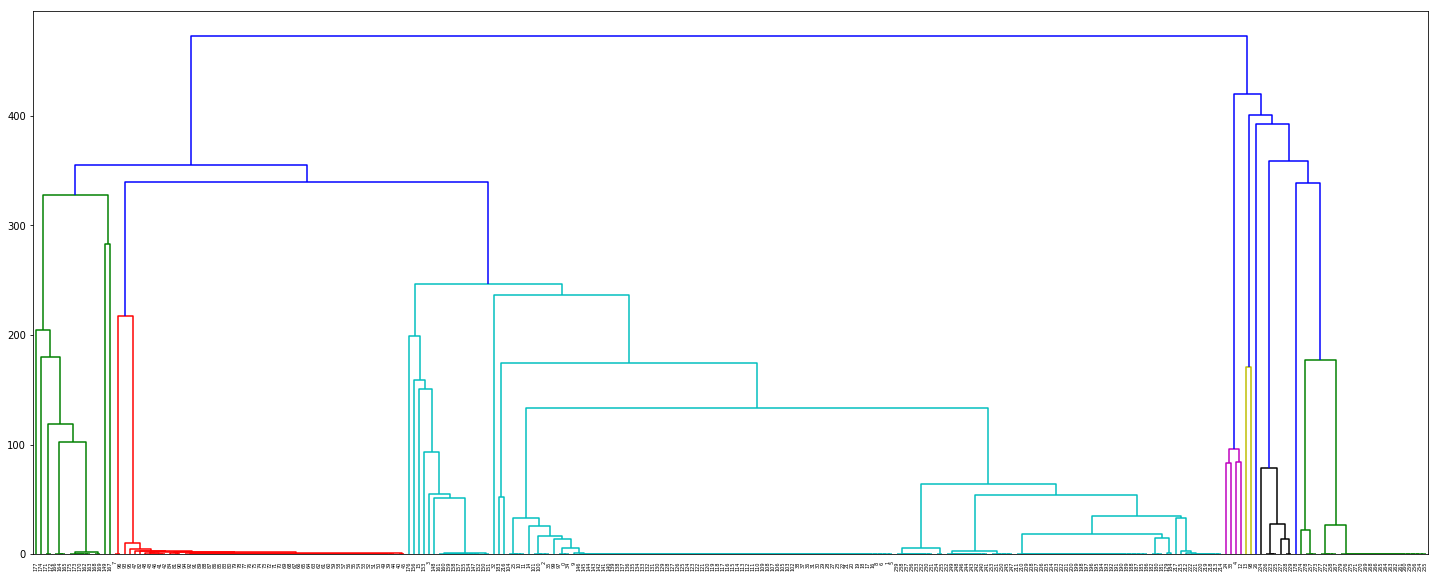

In [24]:
from matplotlib import gridspec
orientation=None
fontsize=16
figsize=(25, 10)
if not orientation:
    if len(df.columns) > 50:
        orientation = 'left'
    else:
        orientation = 'bottom'
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ret = hierarchy.dendrogram(z,
                           orientation=orientation,
                           labels= df.columns.tolist(),
                           distance_sort='descending',
                           link_color_func=lambda c: 'black',
                           leaf_font_size=fontsize,
                           ax=ax0
                           )

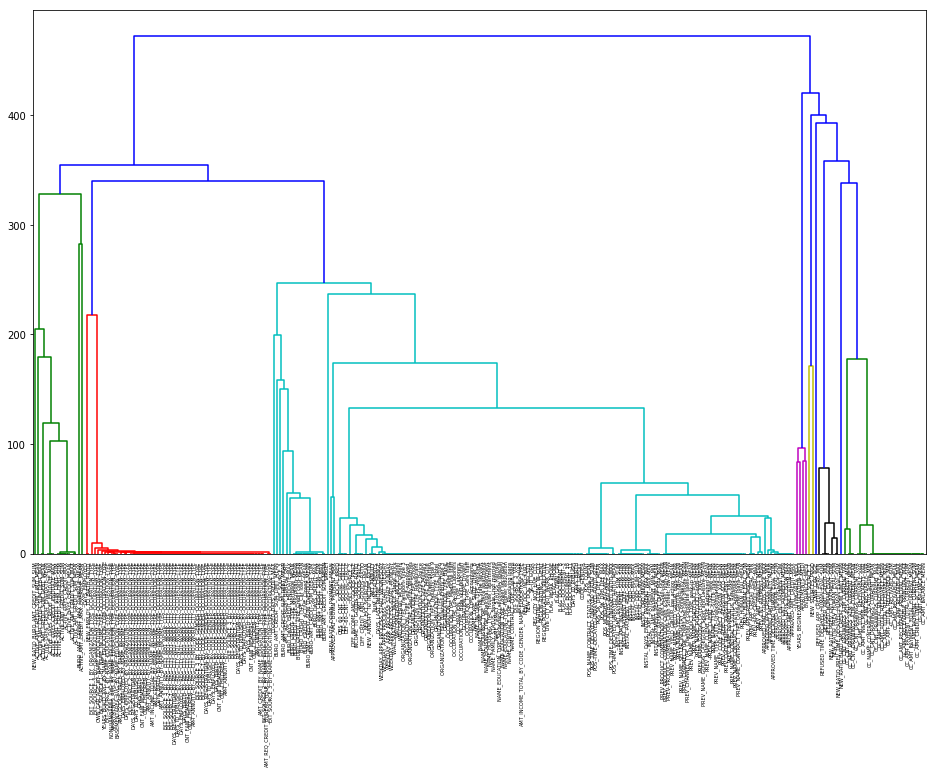

In [101]:
ret1 = hierarchy.dendrogram(z,labels= df.columns.tolist())

In [102]:
for k in ret1.keys():
    print (k)
    print (len(ret1[k]))

icoord
279
dcoord
279
ivl
280
leaves
280
color_list
279


In [103]:
set(ret1['color_list'])

{'b', 'c', 'g', 'k', 'm', 'r', 'y'}

In [104]:
t = 0
b_index = []
c_index = []
y_index = []
for c in ret1['color_list']:
    if c == 'b':
        # a certain cluster
        b_index.append(t)
        t += 1
    elif c == 'c':
        # a certain cluster
        c_index.append(t)
        t += 1
    elif c == 'y':
        # a certain cluster
        y_index.append(t)
        t += 1
    else:
        t += 1

In [97]:
b_index, [ret1['ivl'][i] for i in b_index]

([236, 237, 273, 274, 275, 276, 277, 278],
 ['APPROVED_DAYS_DECISION_MAX',
  'APPROVED_AMT_APPLICATION_MAX',
  'CC_AMT_RECEIVABLE_PRINCIPAL_MAX',
  'CC_AMT_PAYMENT_TOTAL_CURRENT_SUM',
  'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN',
  'CC_AMT_PAYMENT_CURRENT_SUM',
  'CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN',
  'CC_AMT_BALANCE_MAX'])

In [98]:
c_index, [ret1['ivl'][i] for i in c_index]

([73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219

In [105]:
y_index, [ret1['ivl'][i] for i in y_index]

([241], ['APARTMENTS_MEDI'])

# combining hierachical nullity clustering and imputation to clean data

# kmode_cluster usage

In [20]:
import numpy as np
from kmodes.kmodes import KModes

# random categorical data
data = np.random.choice(20, (100, 10))

km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)
km.n_jobs = 32
clusters = km.fit_predict(data)

# Print the cluster centroids
print(km.cluster_centroids_)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 19, cost: 807.0
Run 1, iteration: 2/100, moves: 3, cost: 806.0
Run 1, iteration: 3/100, moves: 0, cost: 806.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 24, cost: 797.0
Run 2, iteration: 2/100, moves: 1, cost: 797.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 21, cost: 811.0
Run 3, iteration: 2/100, moves: 2, cost: 811.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 15, cost: 796.0
Run 4, iteration: 2/100, moves: 3, cost: 796.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 19, cost: 814.0
Run 5, iteration: 2/100, moves: 2, cost: 813.0
Run 5, iteration: 3/100, moves: 1, cost: 813.0
Best run was number 4
[[ 2 17  

In [22]:
import numpy as np
from kmodes.kprototypes import KPrototypes

# random categorical data
data = np.random.choice(20, (100, 10))

km = KPrototypes(n_clusters=4, init='Huang', n_init=5, verbose=1)
km.n_jobs = 32

clusters = km.fit_predict(data)

# Print the cluster centroids
print(km.cluster_centroids_)


NotImplementedError: No categorical data selected, effectively doing k-means. Present a list of categorical columns, or use scikit-learn's KMeans instead.